In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from matplotlib.animation import FuncAnimation
from os import sys
import kagglehub

In [7]:
# Download dataset
fn = kagglehub.dataset_download("brsahan/vehicle-co2-emissions-dataset")
fp = fn + '/co2.csv'
print("Path to dataset files:", fp)

Path to dataset files: /root/.cache/kagglehub/datasets/brsahan/vehicle-co2-emissions-dataset/versions/1/co2.csv


In [11]:
# Load dataset into a dataframe and drop irrelevant columns
all_data = pd.read_csv(fp)
drop_list = ['Make',
             'Model',
             'Vehicle Class',
             'Transmission',
             'Fuel Type'
]
for d in drop_list:
    all_data.drop(d, axis=1, inplace=True)

NameError: name 'describe' is not defined

In [ ]:
all_data.describe()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
count,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000
mean,3.160068,5.615030,12.556534,9.041706,10.975071,27.481652,250.584699
std,1.354170,1.828307,3.500274,2.224456,2.892506,7.231879,58.512679
min,0.900000,3.000000,4.200000,4.000000,4.100000,11.000000,96.000000
25%,2.000000,4.000000,10.100000,7.500000,8.900000,22.000000,208.000000
50%,3.000000,6.000000,12.100000,8.700000,10.600000,27.000000,246.000000
75%,3.700000,6.000000,14.600000,10.200000,12.600000,32.000000,288.000000
max,8.400000,16.000000,30.600000,20.600000,26.100000,69.000000,522.000000


In [79]:
# Correlation to determine the best singular parameter for regression
all_data.corr().style.background_gradient(cmap='coolwarm')


,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
Engine Size(L),1.000000,0.927653,0.831379,0.761526,0.817060,-0.757854,0.851145
Cylinders,0.927653,1.000000,0.800702,0.715252,0.780534,-0.719321,0.832644
Fuel Consumption City (L/100 km),0.831379,0.800702,1.000000,0.948180,0.993810,-0.927059,0.919592
Fuel Consumption Hwy (L/100 km),0.761526,0.715252,0.948180,1.000000,0.977299,-0.890638,0.883536
Fuel Consumption Comb (L/100 km),0.817060,0.780534,0.993810,0.977299,1.000000,-0.925576,0.918052
Fuel Consumption Comb (mpg),-0.757854,-0.719321,-0.927059,-0.890638,-0.925576,1.000000,-0.907426
CO2 Emissions(g/km),0.851145,0.832644,0.919592,0.883536,0.918052,-0.907426,1.000000


In [80]:
# Split into train and test

train_input = np.array(all_data['Fuel Consumption Comb (L/100 km)'][0:5000]).reshape(1,5000)
train_output = np.array(all_data['CO2 Emissions(g/km)'][0:5000]).reshape(1,5000)

test_input = np.array(all_data['Fuel Consumption Comb (L/100 km)'][5000:]).reshape(1,2385)
test_output = np.array(all_data['CO2 Emissions(g/km)'][5000:]).reshape(1,2385)

display(train_input.shape, train_output.shape)
display(test_input.shape, test_output.shape)

(1, 5000)

(1, 5000)

(1, 2385)

(1, 2385)

In [81]:
# Writing the model
class LinearRegression:
    def __init__(self):
        self.parameters = {}

    def forward_propagation(self, train_input):
        m = self.parameters['m']
        c = self.parameters['c']
        predictions = np.multiply(m, train_input) + c
        return predictions

    def cost_function(self, predictions, train_output):
        cost = np.mean((train_output - predictions) ** 2)
        return cost

    def backward_propagation(self, train_input, train_output, predictions):
        derivatives = {}
        df = (predictions-train_output)
        # dm= 2/n * mean of (predictions-actual) * input
        dm = 2 * np.mean(np.multiply(train_input, df))
        # dc = 2/n * mean of (predictions-actual)
        dc = 2 * np.mean(df)
        derivatives['dm'] = dm
        derivatives['dc'] = dc
        return derivatives

    def update_parameters(self, derivatives, learning_rate):
        self.parameters['m'] = self.parameters['m'] - learning_rate * derivatives['dm']
        self.parameters['c'] = self.parameters['c'] - learning_rate * derivatives['dc']

    def train(self, train_input, train_output, learning_rate, iters):
        # Initialize random parameters
        self.parameters['m'] = np.random.uniform(0, 1) * -1
        self.parameters['c'] = np.random.uniform(0, 1) * -1

        # Initialize loss
        self.loss = []

        # Initialize figure and axis for animation
        fig, ax = plt.subplots()
        x_vals = np.linspace(min(train_input[0]), max(train_input[0]), 100)
        y_vals = self.parameters['m'] * x_vals + self.parameters['c']
        line, = ax.plot(x_vals, y_vals, color='red', label='Regression Line')
        ax.scatter(train_input, train_output, marker='o', color='green', label='Training Data')

        # Set y-axis limits to exclude negative values
        ax.set_ylim(0, max(train_output[0]) + 1)

        def update(frame):
            # Forward propagation
            predictions = self.forward_propagation(train_input)

            # Cost function
            cost = self.cost_function(predictions, train_output)

            # Back propagation
            derivatives = self.backward_propagation(
                train_input, train_output, predictions)

            # Update parameters
            self.update_parameters(derivatives, learning_rate)

            # Update the regression line
            line.set_ydata(self.parameters['m'] * x_vals + self.parameters['c'])

            # Append loss and print
            self.loss.append(cost)
            print("Iteration = {}, Loss = {}".format(frame + 1, cost))

            return line,
        # Create animation
        ani = FuncAnimation(fig, update, frames=iters, interval=200, blit=True)

        # Save the animation as a video file (e.g., MP4)
        ani.save('linear_regression_A.gif', writer='ffmpeg')

        plt.xlabel('Input')
        plt.ylabel('Output')
        plt.title('Linear Regression')
        plt.legend()
        plt.show()

        return self.parameters, self.loss

    def predict(self, test_input):
        predictions = np.multiply(self.parameters['m'], test_input) + self.parameters['c']
        return predictions

    def evaluate(self, test_input, test_output):
        predictions = self.predict(test_input)
        loss = self.cost_function(predictions, test_output)
        return loss

Iteration = 1, Loss = 71281.21239132862
Iteration = 1, Loss = 53890.35235754912
Iteration = 1, Loss = 40790.447301973465
Iteration = 1, Loss = 30922.76175532026
Iteration = 2, Loss = 23489.78899586138
Iteration = 3, Loss = 17890.796366899045
Iteration = 4, Loss = 13673.27392087923
Iteration = 5, Loss = 10496.362458035837
Iteration = 6, Loss = 8103.305204969259
Iteration = 7, Loss = 6300.696671283979
Iteration = 8, Loss = 4942.851571953767
Iteration = 9, Loss = 3920.030508010289
Iteration = 10, Loss = 3149.5708022739936
Iteration = 11, Loss = 2569.205682166095
Iteration = 12, Loss = 2132.0318643709697
Iteration = 13, Loss = 1802.7188203470246
Iteration = 14, Loss = 1554.6533546249982
Iteration = 15, Loss = 1367.7887200340185
Iteration = 16, Loss = 1227.0244348375895
Iteration = 17, Loss = 1120.9858582158715
Iteration = 18, Loss = 1041.1048890951051
Iteration = 19, Loss = 980.9274901853917
Iteration = 20, Loss = 935.5920711552151
Iteration = 21, Loss = 901.4365737470786
Iteration = 22, L

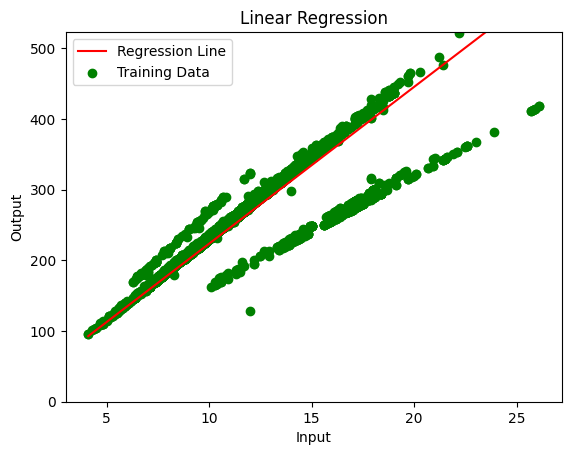

In [82]:
# Training the model
linear_reg = LinearRegression()
parameters, loss = linear_reg.train(train_input, train_output, 0.0005, 100)

Loss = 423.03061435183224


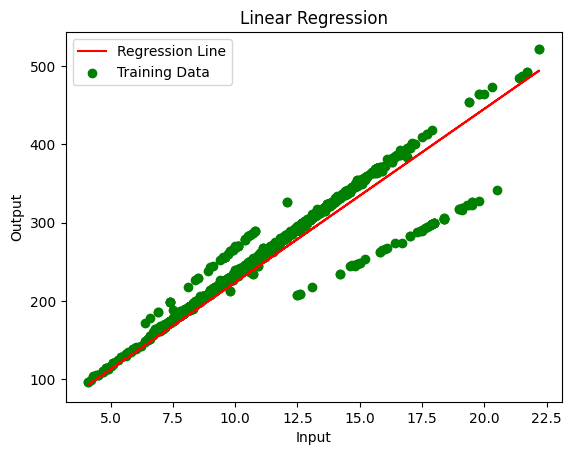

423.03061435183224


In [83]:
# Evaluating the model
predictions = linear_reg.predict(test_input)
loss = linear_reg.cost_function(predictions, test_output)
print("Loss = {}".format(loss))
plt.plot(test_input[0], predictions[0], color='red', label='Regression Line')
plt.scatter(test_input[0], test_output[0], marker='o', color='green', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Linear Regression')
plt.legend()
plt.show()
print(loss)